In [150]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [151]:
import os

if not os.path.exists("Handwritten_V2_train.csv"):
  !gdown 'https://drive.google.com/uc?export=download&id=1phWikkOYex57DGxgNv3PgkF0pQ9Nsm1a'
if not os.path.exists("Handwritten_V2_test.csv"):
  !gdown 'https://drive.google.com/uc?export=download&id=1ykhOpo8ZjgDfbQ2CdR-zN-X_T8WEtL00'
if not os.path.exists("Handwritten_V2_valid.csv"):
  !gdown 'https://drive.google.com/uc?export=download&id=1hzhmO5ZK_aVHUfGeWf3s4bHQPyl5EzUJ'

train = pd.read_csv("Handwritten_V2_train.csv")
test = pd.read_csv("Handwritten_V2_test.csv")
validate = pd.read_csv("Handwritten_V2_valid.csv")

Downloading...
From: https://drive.google.com/uc?export=download&id=1phWikkOYex57DGxgNv3PgkF0pQ9Nsm1a
To: /content/Handwritten_V2_train.csv
100% 35.3M/35.3M [00:00<00:00, 45.7MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1ykhOpo8ZjgDfbQ2CdR-zN-X_T8WEtL00
To: /content/Handwritten_V2_valid.csv
100% 11.7M/11.7M [00:00<00:00, 119MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1hzhmO5ZK_aVHUfGeWf3s4bHQPyl5EzUJ
To: /content/Handwritten_V2_test.csv
100% 13.0M/13.0M [00:00<00:00, 133MB/s]


In [152]:
train_images = train.iloc[:, 1:].values
test_images = test.iloc[:, 1:].values
train_labels = train.iloc[:, 0].values
test_labels = test.iloc[:, 0].values
validate_labels = validate.iloc[:, 0].values
validate_images = validate.iloc[:, 1:].values

num_classes = 85

train_images = np.concatenate([train_images.reshape(-1, 32, 32, 1)] * 3, axis=-1)
test_images = np.concatenate([test_images.reshape(-1, 32, 32, 1)] * 3, axis=-1)
validate_images = np.concatenate([validate_images.reshape(-1, 32, 32, 1)] * 3, axis=-1)


# Rotate train_images by 180 degrees
train_images = tf.image.rot90(train_images, k=3)
# Rotate test_images by 180 degrees
test_images = tf.image.rot90(test_images, k=3)
# Rotate validate_images by 180 degrees
validate_images = tf.image.rot90(validate_images, k=3)

# Mirror images
train_images = tf.image.flip_left_right(train_images)
test_images = tf.image.flip_left_right(test_images)
validate_images = tf.image.flip_left_right(validate_images)


datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

target_per_class = 250
augmented_images = []
augmented_labels = []

for class_idx in range(1, num_classes+1):
    Xc = train_images[train_labels == class_idx]
    print(f"Class {class_idx}: found {Xc.shape[0]} images")
    if Xc.shape[0] == 0:
      continue
    count = Xc.shape[0]
    # Determine how many new images are needed for this class
    need = target_per_class - count
    if need <= 0:
        continue
    # Use flow to generate `need` augmented images for this class
    gen = datagen.flow(Xc, batch_size=1, shuffle=True)
    for _ in range(need):
        batch = next(gen)
        img = batch[0]
        augmented_images.append(img)
        augmented_labels.append(class_idx)

# Combine original and augmented data
x_aug = np.concatenate([train_images, np.array(augmented_images)], axis=0)
y_aug = np.concatenate([train_labels, np.array(augmented_labels)], axis=0)
print(f"Augmented data shape: {x_aug.shape}, labels shape: {y_aug.shape}")

Class 1: found 179 images
Class 2: found 316 images
Class 3: found 192 images
Class 4: found 190 images
Class 5: found 180 images
Class 6: found 183 images
Class 7: found 175 images
Class 8: found 194 images
Class 9: found 204 images
Class 10: found 230 images
Class 11: found 171 images
Class 12: found 228 images
Class 13: found 191 images
Class 14: found 225 images
Class 15: found 234 images
Class 16: found 197 images
Class 17: found 220 images
Class 18: found 198 images
Class 19: found 250 images
Class 20: found 211 images
Class 21: found 202 images
Class 22: found 210 images
Class 23: found 201 images
Class 24: found 186 images
Class 25: found 198 images
Class 26: found 191 images
Class 27: found 205 images
Class 28: found 180 images
Class 29: found 200 images
Class 30: found 209 images
Class 31: found 190 images
Class 32: found 185 images
Class 33: found 197 images
Class 34: found 213 images
Class 35: found 213 images
Class 36: found 215 images
Class 37: found 207 images
Class 38: 

## One hot encoding

In [153]:
y_aug_new = np.array(y_aug) - 1
test_labels_new = np.array(test_labels) - 1
validate_labels_new = np.array(validate_labels) - 1

y_aug_encoded = to_categorical(y_aug_new, num_classes=num_classes)
test_labels_encoded = to_categorical(test_labels_new, num_classes=num_classes)
validate_labels_encoded = to_categorical(validate_labels_new, num_classes=num_classes)

In [154]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
)

In [155]:
base_model.trainable = False
for layer in base_model.layers[-3:]:
    layer.trainable = True

In [156]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(85, activation='softmax')
    ])

In [157]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 85)             │        43,605 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,758,293 (56.30 MB)

 Trainable params: 4,763,221 (18.17 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [158]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [159]:
epochs = 10

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='malayalam_mobilenetv3.keras',
        save_best_only=True,
        monitor='val_accuracy'
    ),
    tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True
    )
]

In [140]:
history = model.fit(
    x_aug, y_aug_encoded,
    epochs=epochs,
    validation_data=(validate_images, validate_labels_encoded),
    callbacks=callbacks,
)

Epoch 1/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.4433 - loss: 2.2282 - val_accuracy: 0.8152 - val_loss: 0.5508
Epoch 2/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8628 - loss: 0.4143 - val_accuracy: 0.8561 - val_loss: 0.4559
Epoch 3/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8988 - loss: 0.3040 - val_accuracy: 0.8941 - val_loss: 0.3416
Epoch 4/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9268 - loss: 0.2251 - val_accuracy: 0.9223 - val_loss: 0.2626
Epoch 5/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9340 - loss: 0.1863 - val_accuracy: 0.9174 - val_loss: 0.2849
Epoch 6/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9362 - loss: 0.2035 - val_accuracy: 0.9178 - val_loss: 0.2905
Epoch 7/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9453 - loss: 0.1699 - val_accuracy: 0.9004 - val_loss: 0.3364
Epoch 8/10
667/667 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9480 - loss: 0.1619 - val

In [141]:
model.evaluate(test_images, test_labels_encoded)

199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8558 - loss: 0.6394


[0.702223539352417, 0.8440006375312805]

In [142]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [143]:
fine_history = model.fit(
    x_aug, y_aug_encoded,
    epochs=12,
    validation_data=(validate_images, validate_labels_encoded),
    initial_epoch=history.epoch[-1]+1,
    callbacks=callbacks
)

Epoch 11/12
667/667 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.9812 - loss: 0.0545 - val_accuracy: 0.9513 - val_loss: 0.1768
Epoch 12/12
667/667 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9935 - loss: 0.0213 - val_accuracy: 0.9564 - val_loss: 0.1750


In [144]:
model.evaluate(test_images, test_labels_encoded)

199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9028 - loss: 0.5182


[0.5642569661140442, 0.8877182006835938]

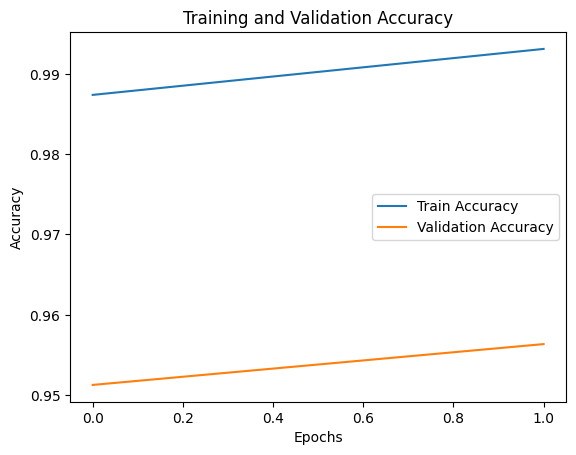

In [145]:
# Plot training history
plt.plot(fine_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [146]:
from tensorflow.keras.models import load_model
best_model = load_model("malayalam_mobilenetv3.keras")

test_loss, test_acc = best_model.evaluate(test_images, test_labels_encoded)

199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9028 - loss: 0.5182


In [147]:
def display_image(img, label):
    plt.imshow(np.mean(img, axis=-1), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(label)
    plt.show()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


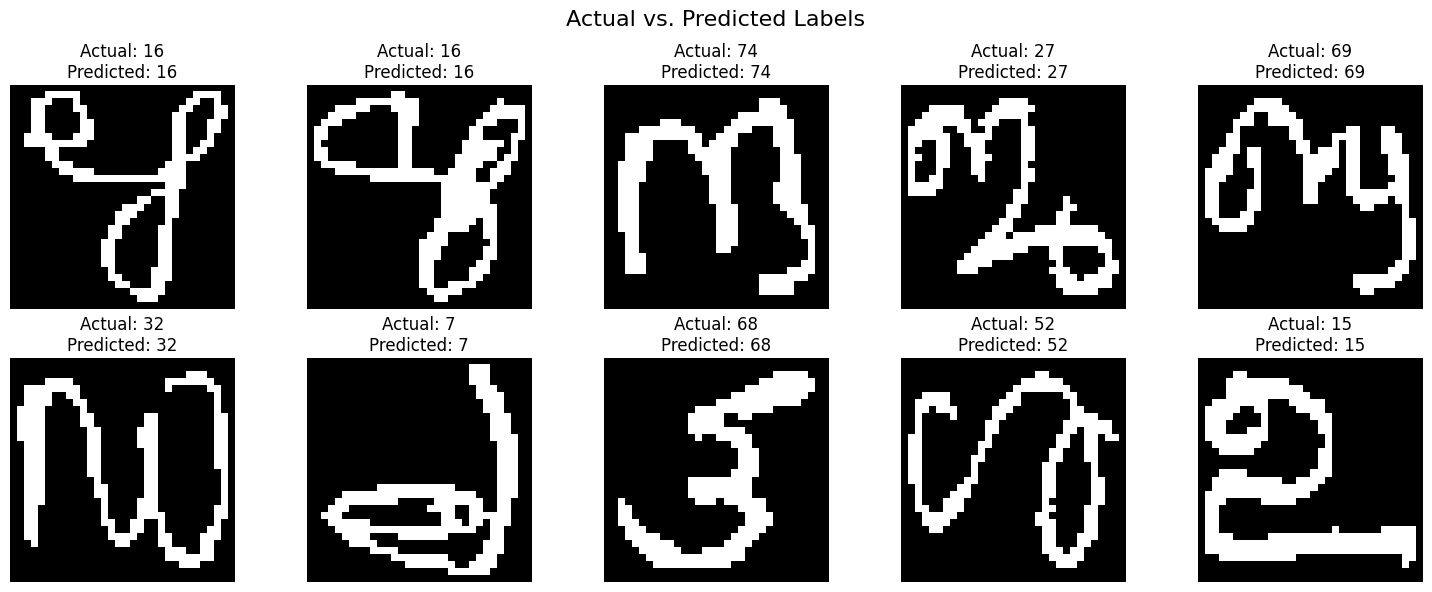

In [148]:
import random

class_names = np.unique(train_labels)
print(class_names)

# Select 10 random images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Actual vs. Predicted Labels", fontsize=16)

for i, ax in enumerate(axes.flat):
    # Randomly select an image index
    random_index = random.randint(0, len(test_images) - 1)

    # Get the image and its actual label
    img_array = test_images[random_index]
    actual_label = test_labels[random_index]

    # Get the prediction
    prediction = model.predict(np.expand_dims(img_array, axis=0))
    predicted_class = class_names[np.argmax(prediction)]

    # Plot the image with actual and predicted labels
    gray_image = np.mean(img_array, axis=-1)
    ax.imshow(gray_image, cmap='gray')
    ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_class}")
    ax.axis("off")

plt.tight_layout()
plt.show()

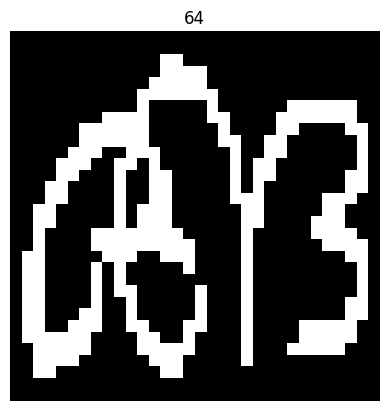

In [160]:
display_image(x_aug[13000], y_aug[13000])